<h1>ANALISI DI DATI CLIMATICI</h1>

<img src = "https://storage.googleapis.com/kaggle-datasets-images/29/33/default-backgrounds/dataset-cover.jpg"></img>

# INTRODUZIONE

In questo progetto verranno analizzati dei dati relativi a temperature registrate nell'arco di molti anni, allo scopo di ottenere, con una analisi nostra analisi, conferme ed evidenze riguardo gli ormai innegabili cambiamenti climatici e l'emergenza che essi rappresentano.

In particolare si cercherà di evidenziare come la tendenza, ormai da molti anni, sia quello di un costante aumento delle temperature a livello globale, cercando di quantificare questo riscaldamento e identificare le zone della terra a esso più soggette.

I dati analizzati sono stati ottenuti a partire dalla sorgente Kaggle <a href="https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data">Climate Change: Earth Surface Temperature Data</a>.
La pagina in questione fornise vari dataset contenenti misurazioni di temperatura a partire dal 1750 fino al 2013:
*   Global Land and Ocean-and-Land Temperatures
*   Global Average Land Temperature by Country
*   Global Average Land Temperature by State
*   Global Land Temperatures By Major City
*   Global Land Temperatures By City 

I vari dataset riportano varie tipologie di dati:



*   Temporali: timestamp nella forma ANNO-MESE, a partire dal 1750 per le    temperature medie, e dal 1850 per le massime e minime.
*   Climatici: temperature medie, massime e minime, relative a terra, oceano o entrambi, misurate in gradi Celsius.
*   Geografici: come coordinate, paesi, provincie o città.
*   Incertezza: l'intervallo di precisione delle misurazioni.

Per le nostre analisi faremo riferimento in particolare al dataset generale contenente temperature globali, e a quello contentente temperature globali per paese.
Cronologicamente, faremo riferimento ai dati successivi all'inizio 1850, essendo questi i più precisi e completi.
Tralasceremo l'incertezza nella valutazione delle misurazioni.








# SETUP - IMPORTAZIONE LIBRERIE E STRUMENTI

Per lo svolgimento dell'analisi, ci avvarremo di vari strumenti.
In particolare faremo affidamento sulla libreria **Pandas** di **Python** per le analisi dei dati, affiancandole poi la piattaforma **Apache Spark** per le operazioni più onerose o da svolgere su dataset di dimensioni consistenti.

Per le visualizzazioni si utilizzeranno **matplotlib** e **plotly**.

**Importazione librerie python**

Per python e librerie annesse possiamo basarci sul runtime di google colab che include di base **Python3**.

In [ ]:
!pip install cufflinks

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px 
import cufflinks as cf
from plotly.offline import iplot

cf.go_offline()
pio.renderers.default = "colab"

**Installazione software**

Installiamo inoltre **Java** e la piattaforma **Apache Spark**

In [50]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark


In [51]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

findspark.init()

In [52]:
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

**CONNESSIONE A GOOGLE DRIVE**

Per l'importazione dei dataset, essendo questi di dimensione non indifferente, non utilizzeremo lo strumento di upload di colab, ma li caricheremo prima in google drive, e da lì li accederemo.

In [53]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Siamo ora pronti per procedere con l'analisi dei dati.

# ANALISI ESPLORATIVA - ANDAMENTO DELLA TEMPERATURA GLOBALE (1850-2013) 

Inizieremo la nostra analisi prendendo in esame il dataset **"GlobalTemperatures"**, cercando di trovare nei dati riscontro alla tendenza di cambiamento climatico che caratterizzal la nostra fase storica. 

E' fornito tramite file csv, che possiamo importare con Pandas.

In [54]:
df_global_temp_full = pd.read_csv("/content/drive/MyDrive/PROGETTO_PDB+BDAV_F_PATANE_530HHHINGINFOR/GlobalTemperatures.csv")
df_global_temp_full

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063


Come accennato nell'introduzione, il dataset contiene dati dal 1750 al 2015, con temperature medie, massime e minime relative alla superficie terrestre includendo o escludendo la superficie oceanica. Vengono riportati anche gli intervalli di incertezza.

Estrapoliamo qualche altra informazione sulla sua struttura.

In [55]:
df_global_temp_full.shape

(3192, 9)

In [56]:
df_global_temp_full.dtypes

dt                                            object
LandAverageTemperature                       float64
LandAverageTemperatureUncertainty            float64
LandMaxTemperature                           float64
LandMaxTemperatureUncertainty                float64
LandMinTemperature                           float64
LandMinTemperatureUncertainty                float64
LandAndOceanAverageTemperature               float64
LandAndOceanAverageTemperatureUncertainty    float64
dtype: object

Le colonne sono già in formato numerico, adatto alle analisi. Riorganizziamo la struttura dividendo il campo temporale in due colonne, **anno** e **mese**. In questo modo potremo analizzare le tendenze annuali o mensili singolarmente.

Eliminiamo inoltre le colonne relative all'incertezza, e i dati precedenti al **1850**, che sono poco accurati e spesso incompleti.

In [57]:
df_global_temp = pd.DataFrame(columns=['year', 'month', 'landAvgTemp', 'landMaxTemp', 'landMinTemp', 'landOceanAvgTemp'])
df_global_temp.year = pd.to_numeric(df_global_temp_full['dt'].str.slice(0, 4))
df_global_temp.month = pd.to_numeric(df_global_temp_full['dt'].str.slice(5, 7))
df_global_temp.landAvgTemp = df_global_temp_full.LandAverageTemperature
df_global_temp.landMaxTemp = df_global_temp_full.LandMaxTemperature
df_global_temp.landMinTemp = df_global_temp_full.LandMinTemperature
df_global_temp.landOceanAvgTemp = df_global_temp_full.LandAndOceanAverageTemperature
df_global_temp = df_global_temp.loc[df_global_temp.year >= 1850]
df_global_temp

,year,month,landAvgTemp,landMaxTemp,landMinTemp,landOceanAvgTemp
1200,1850,1,0.749,8.242,-3.206,12.833
1201,1850,2,3.071,9.970,-2.291,13.588
1202,1850,3,4.954,10.347,-1.905,14.043
1203,1850,4,7.217,12.934,1.018,14.667
1204,1850,5,10.004,15.655,3.811,15.507
...,...,...,...,...,...,...
3187,2015,8,14.755,20.699,9.005,17.589
3188,2015,9,12.999,18.845,7.199,17.049
3189,2015,10,10.801,16.450,5.232,16.290
3190,2015,11,7.433,12.892,2.157,15.252


Come prima analisi esplorativa possiamo rilevare l'andamento nel tempo della temperatura per un dato mese, ed rappresentarlo con un semplice grafico. Prendiamo per esempio gennaio.

Esaminiamo prima le temperature medie.

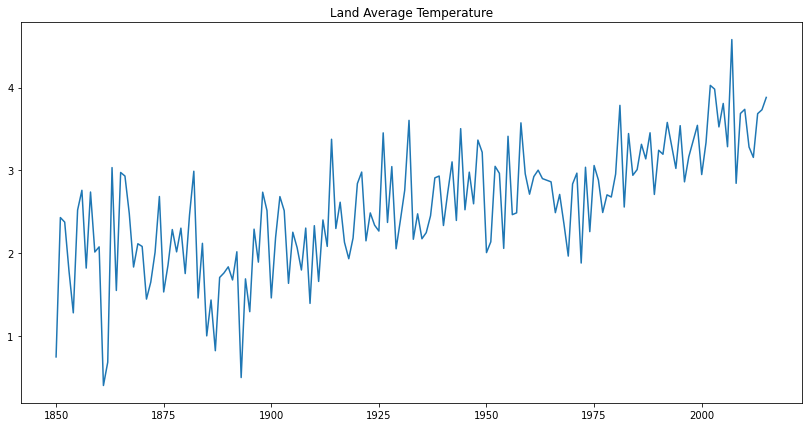

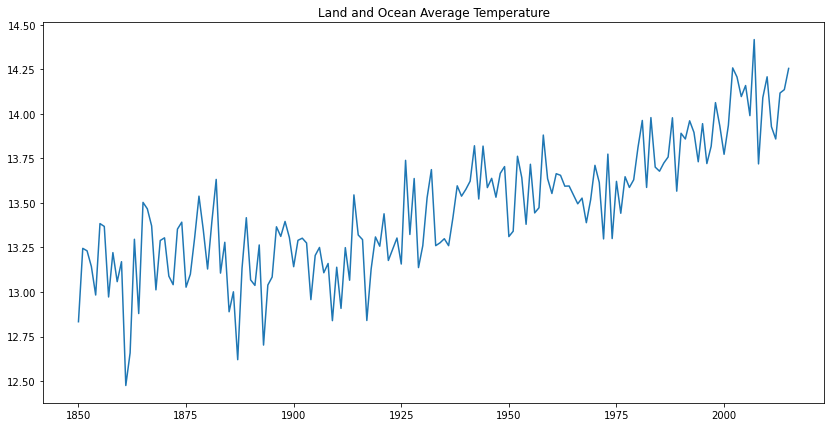

In [58]:
df_global_temp_january = df_global_temp.loc[df_global_temp.month == 1]
plt.figure(figsize=(14,7))
plt.plot(df_global_temp_january.year, df_global_temp_january.landAvgTemp)
plt.title("Land Average Temperature")
plt.show()
plt.figure(figsize=(14,7))
plt.title("Land and Ocean Average Temperature")
plt.plot(df_global_temp_january.year, df_global_temp_january.landOceanAvgTemp)
plt.show()

Già con questa semplice analisi è evidente come il trend sia un aumento delle temperature, con una pronunciata accelerazione negli ultimi 30-50 anni.

Vale anche la pena di notare l'effetto mitigatore degli oceani. Sebbene anche il secondo grafico mostri un aumento dall'andamento analogo al primo, la differenza tra i valori minimi e massimi dell'andamento è di circa 2 gradi nel secondo, metre di circa 4 nel primo.

E ora le temperature minime e massime.

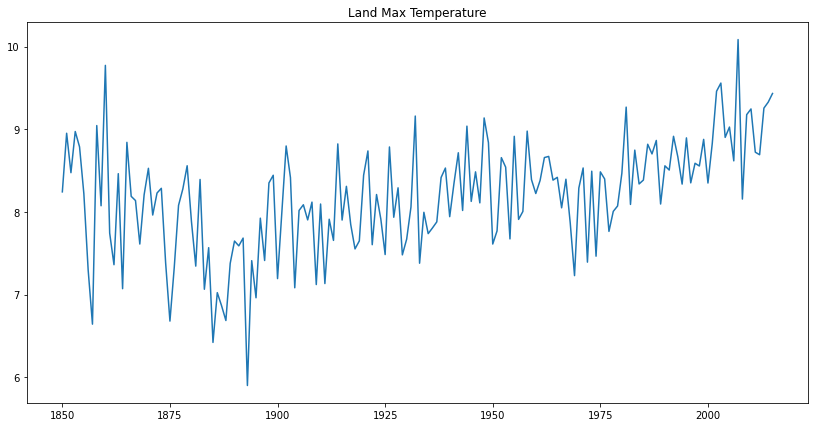

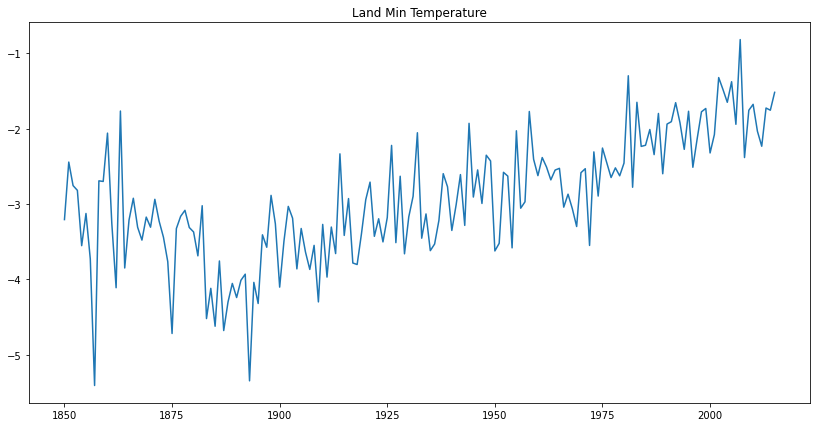

In [59]:
plt.figure(figsize=(14,7))
plt.plot(df_global_temp_january.year, df_global_temp_january.landMaxTemp)
plt.title("Land Max Temperature")
plt.show()
plt.figure(figsize=(14,7))
plt.plot(df_global_temp_january.year, df_global_temp_january.landMinTemp)
plt.title("Land Min Temperature")
plt.show()

Riscontriamo come, sebbene anche prima del 1950 occasionalmente si siano registrati alti valori nella temperatura, gli ultimi 50 anno contengono mediamente temperature più alte.

E' quindi un andamento da considerarsi coerente con quello delle temperature medie.

Concludiamo questa prima analisi con un grafico interattivo che mostri l'andamento della temperatura media terreste di tutti i mesi dell'anno.

In [60]:
fig = px.line(df_global_temp, x='year', y='landAvgTemp', color='month')
fig.show()

E' interessante notare come i mesi con temperature più alte siano giugno, luglio e agosto, mentre quelli con le temperature più fredde dicembre, gennaio e febbraio. Stiamo considerando la temperatura della terra nel suo complesso, eppure sembra che l'intero pianeta segua le stagioni dell'emisfero boreale.

Questo andamento può essere ricondotto al fatto che l'emisfero nord presenta una quantità molto maggiore di terre emerse, e, di conseguenza di attività umana, oltre che una minore estensione degli oceani. Inoltre, buona parte delle terre emerse dell'emisfero sud si trova in Antartide.

Capiamo bene quindi che l'emisfero nord presenta naturalmente delle temperature superiori a quello sud, la cui presenza è comunque presente, come si può desumere dalla mitigazione del valore medio di temperatura, che anche a luglio non arriva nemmeno a 20 gradi.



# ANALISI - INCREMENTO DELLA TEMPERATURA RISPETTO ALLA SECONDA META' DEL 1800

Una delle questione più complesse per quanto concerne il problema dei cambiamenti climatici, è comprendere in quale misura essi siano un processo naturale o dipendano dall'attività umana.

Sappiamo che la temperatura della terra è in aumento dalla fine della cosiddetta "piccola era glaciale", un periodo insolitamente freddo della storia del mondo, che ha interessato il periodo tra circa la metà del XIV e la metà del XIX secolo.

Sappiamo inoltre che le basi dell'industrializzazione attuale, la principale causa umana del riscaldamento globale, per via delle sue emissioni, hanno avuto origine dalle rivoluzioni industriali, in particolare dalla seconda, che ha introdotto la produzione di massa e gli idrocarburi. Queste innovazioni hanno poi avuto una crescita esponenziale nell'ultimo secolo, portando nel corso del '900 a un'accelerazione del riscaldamento globale.

Vogliamo cercare conferma di queste tesi nei nostri dati. Una possibile strategia potrebbe essere quella di calcolare le temperature medie per il periodo 1850-1899, e confrontarle con le medie degli anni successivi. Questo intervallo temporale è appropriato in quanto la metà dell'800 è considerata approssimativamente la fine della piccola era glaciale e allo stesso tempo l'inizio della seconda rivoluzione industriale.





Cominciamo con il calcolo delle temperature medie aggregate per tutti i mesi dell'anno, per gli anni precedenti al 1900.



In [61]:
pre_900_avg_temp_by_month = df_global_temp.loc[df_global_temp.year < 1900].groupby('month').agg({'landAvgTemp':'mean','landOceanAvgTemp':'mean'})
pre_900_avg_temp_by_month

,landAvgTemp,landOceanAvgTemp
month,,
1,1.92832,13.16464
2,2.48680,13.45142
3,4.58508,14.06598
4,7.83092,14.95326
5,10.88538,15.75732
6,13.11816,16.37998
7,14.18684,16.72504
8,13.55560,16.60846
9,11.60374,15.98404


Riduciamo ora il dataset ai soli record successivi a fine '800.

In [62]:
df_post_900_avg_temp = df_global_temp.loc[df_global_temp.year >= 1900]
df_post_900_avg_temp.drop(['landMaxTemp', 'landMinTemp'], inplace=True, axis=1)
df_post_900_avg_temp

,year,month,landAvgTemp,landOceanAvgTemp
1800,1900,1,1.461,13.142
1801,1900,2,3.098,13.777
1802,1900,3,5.492,14.400
1803,1900,4,8.223,15.170
1804,1900,5,11.385,15.955
...,...,...,...,...
3187,2015,8,14.755,17.589
3188,2015,9,12.999,17.049
3189,2015,10,10.801,16.290
3190,2015,11,7.433,15.252


Aggiungiamo al dataset ottenuto, per ogni suo record,  i dati relativi alle medie pre-900 relative al mese corrispondente. 

In [63]:
new_col = df_post_900_avg_temp.apply (lambda row: pre_900_avg_temp_by_month.landAvgTemp[row.month], axis=1)
df_post_900_avg_temp = df_post_900_avg_temp.assign(landAvgTemp_1850_1899 = new_col.values)
new_col = df_post_900_avg_temp.apply (lambda row: pre_900_avg_temp_by_month.landOceanAvgTemp[row.month], axis=1)
df_post_900_avg_temp = df_post_900_avg_temp.assign(landOceanAvgTemp_1850_1899 = new_col.values)
df_post_900_avg_temp

,year,month,landAvgTemp,landOceanAvgTemp,landAvgTemp_1850_1899,landOceanAvgTemp_1850_1899
1800,1900,1,1.461,13.142,1.92832,13.16464
1801,1900,2,3.098,13.777,2.48680,13.45142
1802,1900,3,5.492,14.400,4.58508,14.06598
1803,1900,4,8.223,15.170,7.83092,14.95326
1804,1900,5,11.385,15.955,10.88538,15.75732
...,...,...,...,...,...,...
3187,2015,8,14.755,17.589,13.55560,16.60846
3188,2015,9,12.999,17.049,11.60374,15.98404
3189,2015,10,10.801,16.290,8.88678,15.09874
3190,2015,11,7.433,15.252,5.45528,14.06548


Cerchiamo ora di calcolare per ogni anno a partire dal '900 lo scostamento medio rispetto alla temperatura media del periodo antecedente al '900. 

Per il proseguio dell'analisi applicheremo un approccio Map-Reduce, confrontando la temperatura media di ogni mese di ogni anno a partire dal '900 con la temperatura media di quel mese nel periodo pre '900 calcolato. 

E' conveniente avvalersi della piattaforma Apache Spark. Useremo il dataset appena impostato come imput per l'elaborazione.

In [64]:
spark_df_temp_shift = spark.createDataFrame(df_post_900_avg_temp)
spark_df_temp_shift.show()

+----+-----+------------------+------------------+---------------------+--------------------------+
|year|month|       landAvgTemp|  landOceanAvgTemp|landAvgTemp_1850_1899|landOceanAvgTemp_1850_1899|
+----+-----+------------------+------------------+---------------------+--------------------------+
|1900|    1|             1.461|            13.142|              1.92832|        13.164639999999999|
|1900|    2|3.0980000000000003|            13.777|               2.4868|                  13.45142|
|1900|    3| 5.492000000000001|              14.4|   4.5850800000000005|                  14.06598|
|1900|    4| 8.222999999999999|             15.17|    7.830919999999999|                  14.95326|
|1900|    5|            11.385|            15.955|             10.88538|                  15.75732|
|1900|    6|            13.293|            16.515|             13.11816|                  16.37998|
|1900|    7|            14.171|            16.785|             14.18684|                  16.72504|


Applichiamo ora Map-Reduce: aggregeremo il valore medio della temperatura annualmente, quindi adotteremo l'anno come key nella fase di map, in base alla quale aggregeremo come valori la differenza di temperatura media tra i vari mesi di quell'anno con i mesi corrispondenti pre '900, per poi calcolarne la media aggregata nella fase di reduce, ottenendo lo scostamento medio annuale.

MAP: (YYYY, [vM1, vM2 ... vM12])

REDUCE: (YYYY, avg([vM1...12]))



 

In [65]:
monthly_shifts_by_year_landAvgTemp = spark_df_temp_shift.rdd.map(lambda row: (row.year, [row.landAvgTemp - row.landAvgTemp_1850_1899])).reduceByKey(lambda a,b:a+b)
shifts_by_year_landAvgTemp = monthly_shifts_by_year_landAvgTemp.map(lambda e: (e[0], sum(e[1]) / len(e[1]))).collect()

Otteniamo l'output come lista di tuple contenenti anno e

In [66]:
shifts_by_year_landAvgTemp[0:10]

[(1900, 0.37282166666666666),
 (1901, 0.4131550000000004),
 (1902, 0.17565500000000003),
 (1903, 0.09140500000000013),
 (1904, -0.037845000000000205),
 (1905, 0.09640499999999975),
 (1906, 0.2503216666666665),
 (1907, -0.18159499999999995),
 (1908, 0.05732166666666644),
 (1909, 0.049488333333333634)]

In [67]:
monthly_shifts_by_year_landOceanAvgTemp = spark_df_temp_shift.rdd.map(lambda row: (row.year, [row.landOceanAvgTemp - row.landOceanAvgTemp_1850_1899])).reduceByKey(lambda a,b:a+b)
shifts_by_year_landOceanAvgTemp = monthly_shifts_by_year_landOceanAvgTemp.map(lambda e: (e[0], sum(e[1]) / len(e[1]))).collect()

In [68]:
shifts_by_year_landOceanAvgTemp[0:10]

[(1900, 0.17370833333333366),
 (1901, 0.10312500000000036),
 (1902, -0.011875000000000005),
 (1903, -0.13362499999999988),
 (1904, -0.1597916666666658),
 (1905, -0.015541666666666712),
 (1906, 0.06170833333333311),
 (1907, -0.09537500000000006),
 (1908, -0.1320416666666664),
 (1909, -0.17987499999999912)]

Diamo una rappresentazione grafica di questo scostamento. Un valore superiore allo 0 indica una temperatura media superiore alla media pre '900, inferiore allo 0 una temperatura media inferiore.

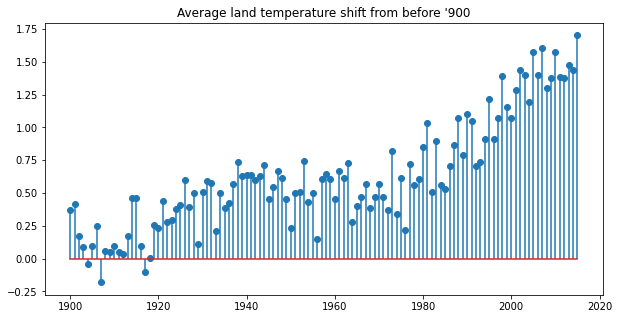

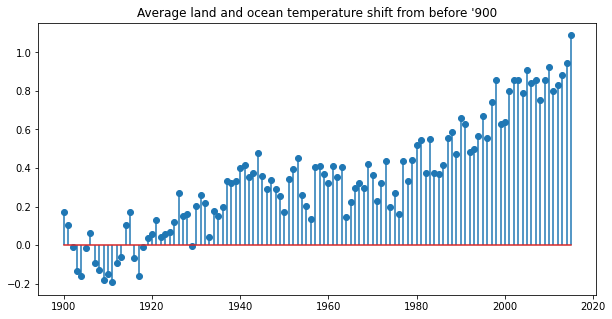

In [69]:
x_val_landAvgTemp = [x[0] for x in shifts_by_year_landAvgTemp]
y_val_landAvgTemp = [y[1] for y in shifts_by_year_landAvgTemp]
plt.figure(figsize=(10,5))
plt.stem(x_val_landAvgTemp, y_val_landAvgTemp, use_line_collection=True)
plt.title("Average land temperature shift from before '900")
plt.show()

x_val_landOceanAvgTemp = [x[0] for x in shifts_by_year_landOceanAvgTemp]
y_val_landOceanAvgTemp = [y[1] for y in shifts_by_year_landOceanAvgTemp]
plt.figure(figsize=(10,5))
plt.stem(x_val_landOceanAvgTemp, y_val_landOceanAvgTemp, use_line_collection=True)
plt.title("Average land and ocean temperature shift from before '900")
plt.show()

Possiamo osservare come nei primi decenni del '900 non ci fossero eccessivi scostamenti rispetto ala seconda metà del secolo precedente, anzi, occasionalmente le temperature sono state anche inferiori. Ma avvicinandoci al momento attuale l'aumento della temperatura è stato sempre più marcato, con un'accelerazione importante negli ultimi 50 anni.

Riportiamo entrambi gli andamenti in un unico grafico. (Arancio temperature terrestri, azzurro terrestri e oceaniche)

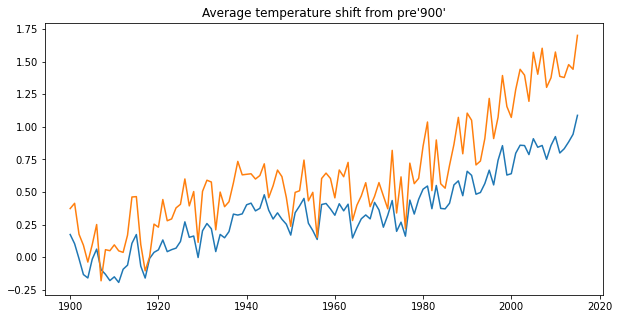

In [70]:
plt.figure(figsize=(10,5))
plt.plot(x_val_landOceanAvgTemp, y_val_landOceanAvgTemp)
plt.plot(x_val_landAvgTemp, y_val_landAvgTemp)
plt.title("Average temperature shift from pre'900'")
plt.show()

Possiamo osservare ancora una volta l'azione mitigatrice degli oceani.

Dall'analisi appena compiuta troviamo conferma alle affermazioni scientifiche sul cambiamento climatico: la terra è effettivamente in un periodo di riscaldamento, ma l'intensità e la velocità di questo cambiamento è pesantemente influenzata dall'attività umana.

Appurato questo, potremmo chiederci se, con l'aumentare della temperatura, sia aumentato anche il divario tra temperatura minima e massima registrata, ovvero l'escursione termica.

Proviamo a verificarlo al livello più basso consentito dai nostri dati: calcoleremo come escursione termica annuale la media delle singole escursioni termiche dei singoli mesi.

Per prima cosa riorganizziamo il dataset.

In [71]:
new_col = df_global_temp.apply (lambda row: (row.landMaxTemp - row.landMinTemp), axis=1)
df_termal_excursion = df_global_temp.assign(termalExcursion = new_col.values)

df_termal_excursion

,year,month,landAvgTemp,landMaxTemp,landMinTemp,landOceanAvgTemp,termalExcursion
1200,1850,1,0.749,8.242,-3.206,12.833,11.448
1201,1850,2,3.071,9.970,-2.291,13.588,12.261
1202,1850,3,4.954,10.347,-1.905,14.043,12.252
1203,1850,4,7.217,12.934,1.018,14.667,11.916
1204,1850,5,10.004,15.655,3.811,15.507,11.844
...,...,...,...,...,...,...,...
3187,2015,8,14.755,20.699,9.005,17.589,11.694
3188,2015,9,12.999,18.845,7.199,17.049,11.646
3189,2015,10,10.801,16.450,5.232,16.290,11.218
3190,2015,11,7.433,12.892,2.157,15.252,10.735


Ora visualizziamo l'andamento dell'escursione termica.

In [72]:
termalExcursion = df_termal_excursion.groupby('year').termalExcursion.mean()
fig = px.line(termalExcursion, title='Termal Excursion')
fig.show()

E' curioso notare come l'escursione termica si sia ridotta nel tempo, nonostante la realtà dei cambiamenti climatici ci porterebbe a pensare a una estremizzazione del clima.

Da una rapida ricerca sembra invece che per cause poco comprese il riscaldamento globale porti a una diminuzione dell'escursione termica tra giorno e notte, il che sembra supportare la nostra rilevazione. 

https://www.repubblica.it/green-and-blue/2022/10/27/news/piu_nuvole_meno_escursione_termica_giornaliera_cambiamenti_climatici-371921281/

https://greenreport.it/news/clima/il-cambiamento-climatico-sta-colmando-il-divario-termico-tra-giorno-e-notte/

# ANALISI - IMPATTO DEI CAMBIAMENTI CLIMATICI NEI PAESI DEL MONDO (1850-2013) 

Nelle analisi precedenti abbiamo considerato dei dati che consideravano la temperatura della terra nel suo complesso. Sarebbe interessante anche indagare su quanto il cambiamento interessi i singoli paesi.

A tale scopo esaminiamo un secondo dataset, **GlobalLandTemperaturesByCountry**. Anche questo è fornito come file csv, ma è di dimensioni superiori rispetto al dataset precedente. Lo esamineremo fin dall'inizio con Spark.

In [74]:
df_temps_by_country = spark.read.options(header='True', delimiter=',', inferSchema='True').csv("/content/drive/MyDrive/PROGETTO_PDB+BDAV_F_PATANE_530HHHINGINFOR/GlobalLandTemperaturesByCountry.csv")
df_temps_by_country.printSchema()
df_temps_by_country.show()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)

+-------------------+-------------------+-----------------------------+-------+
|                 dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+-------------------+-------------------+-----------------------------+-------+
|1743-11-01 00:00:00| 4.3839999999999995|                        2.294|  Åland|
|1743-12-01 00:00:00|               null|                         null|  Åland|
|1744-01-01 00:00:00|               null|                         null|  Åland|
|1744-02-01 00:00:00|               null|                         null|  Åland|
|1744-03-01 00:00:00|               null|                         null|  Åland|
|1744-04-01 00:00:00|               1.53|                         4.68|  Åland|
|1744-05-01 00:00:00|  6.702000000000001|                        1.789|  Åland|
|1744-0

Riorganizziamo il dataset scomponendo la data, tralasciando l'incertezza e i record antecedenti al 1850, o che non abbiamo dati di temperatura media.

In [75]:
df_temps_by_country=df_temps_by_country.withColumn('Year', col('dt').substr(1, 4))
df_temps_by_country = df_temps_by_country.filter(df_temps_by_country.Year >= 1850)
df_temps_by_country = df_temps_by_country.filter(df_temps_by_country.AverageTemperature.isNotNull())
df_temps_by_country = df_temps_by_country.drop("dt", "AverageTemperatureUncertainty")
df_temps_by_country.show()

+-------------------+-------+----+
| AverageTemperature|Country|Year|
+-------------------+-------+----+
| -9.082999999999998|  Åland|1850|
|             -2.309|  Åland|1850|
|             -4.801|  Åland|1850|
|              1.242|  Åland|1850|
|               7.92|  Åland|1850|
|             12.704|  Åland|1850|
| 15.905999999999999|  Åland|1850|
| 16.317999999999998|  Åland|1850|
| 10.483999999999998|  Åland|1850|
|  5.218999999999999|  Åland|1850|
| 0.6859999999999999|  Åland|1850|
| 1.4980000000000002|  Åland|1850|
|-1.4399999999999995|  Åland|1851|
|             -3.052|  Åland|1851|
|-4.5280000000000005|  Åland|1851|
|              2.117|  Åland|1851|
|              4.945|  Åland|1851|
|             11.352|  Åland|1851|
|             14.741|  Åland|1851|
|             14.122|  Åland|1851|
+-------------------+-------+----+
only showing top 20 rows



Raggruppiamo i dati per anno e paese, ottenendo la temperatura media di ogni coppia anno-paese.

In [76]:
df_temps_by_country_year = df_temps_by_country.groupby("Year", "Country").mean("AverageTemperature").sort("Year")
df_temps_by_country_year = df_temps_by_country_year.withColumnRenamed("avg(AverageTemperature)","AverageTemperature")
df_temps_by_country_year.show()

+----+--------------------+-------------------+
|Year|             Country| AverageTemperature|
+----+--------------------+-------------------+
|1850|              Bhutan| 12.212727272727273|
|1850|              France|            12.2175|
|1850|               Qatar|           25.90675|
|1850|       Côte D'Ivoire|  25.35358333333333|
|1850|Saint Kitts And N...| 25.355249999999998|
|1850|              Guyana| 25.531916666666664|
|1850|         North Korea|  5.616583333333332|
|1850|        Saint Martin|  26.10633333333334|
|1850|               Aruba|  27.43816666666667|
|1850|                Iraq|             20.919|
|1850|              Malawi|  20.49909090909091|
|1850|              Mexico|            20.3065|
|1850|              Norway|-0.5644166666666662|
|1850|             Belgium|  8.778083333333333|
|1850|              Kuwait| 24.192500000000006|
|1850|         El Salvador| 24.709916666666672|
|1850|          Seychelles| 26.034909090909093|
|1850|              Jersey| 10.611999999

Possiamo estrapolare gli andamenti della temperatura negli anni per i singoli paesi. Visualizziamone alcune a campione, a scopo esplorativo.

In [77]:
df_italy_temp = df_temps_by_country_year.filter(df_temps_by_country.Country == 'Italy').toPandas()
fig = px.line(df_italy_temp, x="Year", y="AverageTemperature", title='Italy average temperature')
fig.show()


In [78]:
df_argentina_temp = df_temps_by_country_year.filter(df_temps_by_country.Country == 'Argentina').toPandas()
fig = px.line(df_argentina_temp, x="Year", y="AverageTemperature", title='Argentina average temperature')
fig.show()

Per ottenere un'idea complessiva dell'effetto dei cambiamenti climatici a livello geografico su scala mondiale, proveremo a quantificare l'impatto del riscaldamento globale sui singoli paesi.

Adotteremo una strategia analoga a quella adoperata precedentemente per calcolare l'accelerazione del cambiamento climatico: confronteremo la temperatura mediaaggregata successiva al '900 dei singoli paesi con la media aggregata delle temperature precedenti al '900.


In [80]:
df_temps_by_country_pre_900 = df_temps_by_country_year.filter((df_temps_by_country_year.Year >= 1850) & (df_temps_by_country_year.Year <= 1899))
df_temps_by_country_pre_900 = df_temps_by_country_pre_900.groupby("Country").mean("AverageTemperature").sort("Country").withColumnRenamed("avg(AverageTemperature)","Pre900AverageTemperature")
df_temps_by_country_pre_900.show()

+-------------------+------------------------+
|            Country|Pre900AverageTemperature|
+-------------------+------------------------+
|        Afghanistan|      13.659380000000004|
|             Africa|      23.633927441077443|
|            Albania|       12.34541333333333|
|            Algeria|       22.71968666666667|
|     American Samoa|      26.056831718614706|
|            Andorra|      10.932779999999998|
|             Angola|       21.31464187983734|
|           Anguilla|                26.21328|
|Antigua And Barbuda|      26.042521666666666|
|          Argentina|       14.11061481481481|
|            Armenia|       8.293576666666668|
|              Aruba|      27.523678333333336|
|               Asia|       6.986439999999998|
|          Australia|      21.327961752946127|
|            Austria|      5.8828700000000005|
|         Azerbaijan|      10.921328333333333|
|            Bahamas|                24.85989|
|            Bahrain|               25.577335|
|       Baker

In [81]:
df_temps_by_country_post_900 = df_temps_by_country_year.filter(df_temps_by_country_year.Year >= 1900)
df_temps_by_country_post_900 = df_temps_by_country_post_900.groupby("Country").mean("AverageTemperature").sort("Country").withColumnRenamed("avg(AverageTemperature)","Post900AverageTemperature")
df_temps_by_country_post_900.show()

+-------------------+-------------------------+
|            Country|Post900AverageTemperature|
+-------------------+-------------------------+
|        Afghanistan|       14.232601242690059|
|             Africa|       24.245091374269016|
|            Albania|       12.892144371345026|
|            Algeria|        23.27163669590643|
|     American Samoa|       26.721842105263164|
|            Andorra|       11.464675073099414|
|             Angola|       21.963944078947364|
|           Anguilla|        26.81302923976608|
|Antigua And Barbuda|       26.640270102339173|
|          Argentina|       14.813802997076028|
|            Armenia|        8.906145467836259|
|              Aruba|        28.12237499999999|
|               Asia|        7.647457967836258|
|          Australia|       21.741311769005844|
|            Austria|        6.500579312865501|
|         Azerbaijan|       11.529938961988309|
|            Bahamas|       25.323319444444444|
|            Bahrain|       26.125306652

Uniamo i due dataset.

In [82]:
df_shifts_by_country = df_temps_by_country_post_900.join(df_temps_by_country_pre_900, "Country").sort("Country")
df_shifts_by_country.show()

+-------------------+-------------------------+------------------------+
|            Country|Post900AverageTemperature|Pre900AverageTemperature|
+-------------------+-------------------------+------------------------+
|        Afghanistan|       14.232601242690059|      13.659380000000004|
|             Africa|       24.245091374269016|      23.633927441077443|
|            Albania|       12.892144371345026|       12.34541333333333|
|            Algeria|        23.27163669590643|       22.71968666666667|
|     American Samoa|       26.721842105263164|      26.056831718614706|
|            Andorra|       11.464675073099414|      10.932779999999998|
|             Angola|       21.963944078947364|       21.31464187983734|
|           Anguilla|        26.81302923976608|                26.21328|
|Antigua And Barbuda|       26.640270102339173|      26.042521666666666|
|          Argentina|       14.813802997076028|       14.11061481481481|
|            Armenia|        8.906145467836259|    

Calcolando la differenza tra la temperatura post e pre '900, otteniamo una misura dello scostamento climatico: un valore positivo indica un'aumento di temperatura rispetto al periodo 185-1899, un valore negativo una diminuzione.

In [84]:
df_shifts_by_country= df_shifts_by_country.withColumn('TemperatureShift', df_shifts_by_country.Post900AverageTemperature - df_shifts_by_country.Pre900AverageTemperature).orderBy(col("TemperatureShift").desc())
df_shifts_by_country.show()

+--------------------+-------------------------+------------------------+------------------+
|             Country|Post900AverageTemperature|Pre900AverageTemperature|  TemperatureShift|
+--------------------+-------------------------+------------------------+------------------+
|           Greenland|       -18.17757090643275|     -19.264661666666665|1.0870907602339166|
|             Denmark|      -17.646652777777778|     -18.723821666666666|1.0771688888888882|
|              Canada|       -4.736779239766081|      -5.703153333333335|0.9663740935672536|
|Svalbard And Jan ...|       -7.069910087719295|      -7.915264999999998|0.8453549122807029|
|             Finland|       1.6756151315789474|      0.8509549999999999|0.8246601315789475|
|        Burkina Faso|        28.29078216374269|        27.4852981000481| 0.805484063694589|
|                Togo|       27.065098684210533|       26.26036353114478|0.8047351530657529|
|Sao Tome And Prin...|       25.971334064327497|       25.174690427383

Già a colpo d'occhio vediamo che il riscaldamento è stato più pronunciato nelle regioni prossime ai poli (Danimarca/Groenlandia, Canada...) e in quelle equatoriali (Burkina Faso, Togo...)

Invertiamo l'ordinamento.

In [85]:
df_shifts_by_country = df_shifts_by_country.orderBy(col("TemperatureShift").asc())
df_shifts_by_country.show()

+--------------------+-------------------------+------------------------+-------------------+
|             Country|Post900AverageTemperature|Pre900AverageTemperature|   TemperatureShift|
+--------------------+-------------------------+------------------------+-------------------+
|South Georgia And...|        1.435637327219564|       1.396020661157025|  0.039616666062539|
|            Djibouti|        28.88698903508773|       28.52489863636363| 0.3620903987240993|
|             Eritrea|       26.877444444444453|       26.49376442307692|0.38368002136753177|
|               Nepal|       15.055956871345028|      14.651772915198496|0.40418395614653235|
|           Australia|       21.741311769005844|      21.327961752946127|0.41335001605971655|
|            Portugal|        14.92699707602339|      14.499241666666666|0.42775540935672396|
|             Ireland|        9.689604532163749|        9.26069833333333|0.42890619883041836|
|             Oceania|       21.575079678362577|       21.14

Vediamo come non ci sia nemmeno un caso di diminuzione della temperatura. Sebbene in misura e con tempi diversi, il riscaldamento globale è una tendenza chiara a livello globale.

Diamo ora una rappresentazione visuale della tendenza dei paesi più colpiti.

In [86]:
df_shifts_by_country = df_shifts_by_country.orderBy(col("TemperatureShift").desc())
fig = px.bar(df_shifts_by_country.toPandas().head(20), x='Country', y='TemperatureShift')
fig.show()

Vogliamo però anche una rappresentazione visuale che ricopra tutto il globo. A tale scopo useremo un grafico choropleth di Plotly, che però richiede i codici ISO dei vari paesi.

Possiamo recuperarli da un apposito file.

In [88]:
cc_df = pd.read_csv("/content/drive/MyDrive/PROGETTO_PDB+BDAV_F_PATANE_530HHHINGINFOR/iso_codes.csv")
cc_df

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""
2,Algeria,"""DZ""","""DZA""","""12""","""28""","""3"""
3,American Samoa,"""AS""","""ASM""","""16""","""-14.3333""","""-170"""
4,Andorra,"""AD""","""AND""","""20""","""42.5""","""1.6"""
...,...,...,...,...,...,...
260,Wallis and Futuna,"""WF""","""WLF""","""876""","""-13.3""","""-176.2"""
261,Western Sahara,"""EH""","""ESH""","""732""","""24.5""","""-13"""
262,Yemen,"""YE""","""YEM""","""887""","""15""","""48"""
263,Zambia,"""ZM""","""ZMB""","""894""","""-15""","""30"""


Arricchiamo il nostro dataset con i codici a 3 caratteri.

In [89]:
def getIsoCode(country):
  result_df = cc_df.loc[cc_df.Country ==  country]
  if (result_df.empty):
    return "NA"
  else:
    result = result_df['Alpha-3 code'].iloc[0].replace('"', '').replace(' ', '')
  return result

df_shifts_by_country_p = df_shifts_by_country.toPandas()
new_col = df_shifts_by_country_p.apply((lambda row: getIsoCode(row.Country)), axis=1)
df_shifts_by_country_p = df_shifts_by_country_p.assign(ISO = new_col.values)
df_shifts_by_country_p

,Country,Post900AverageTemperature,Pre900AverageTemperature,TemperatureShift,ISO
0,Greenland,-18.177571,-19.264662,1.087091,GRL
1,Denmark,-17.646653,-18.723822,1.077169,DNK
2,Canada,-4.736779,-5.703153,0.966374,CAN
3,Svalbard And Jan Mayen,-7.069910,-7.915265,0.845355,NA
4,Finland,1.675615,0.850955,0.824660,FIN
...,...,...,...,...,...
233,Australia,21.741312,21.327962,0.413350,AUS
234,Nepal,15.055957,14.651773,0.404184,NPL
235,Eritrea,26.877444,26.493764,0.383680,ERI
236,Djibouti,28.886989,28.524899,0.362090,DJI


Ora siamo pronti per la visualizzazione conclusiva.

In [90]:
fig = px.choropleth(df_shifts_by_country_p, locations="ISO",
                    color="TemperatureShift", 
                    hover_name="Country", 
                    color_continuous_scale=px.colors.sequential.Turbo)
fig.show()

Confermiamo la nostra precedente evidenza: i paesi più colpiti sono quelli nei pressi delle regioni polari e equatoriali, ma tutti i paesi nel mondo, in misura differente, subiscono l'impatto del riscaldamento globale.

# CONCLUSIONI

Lo scopo prefissato di questa analisi era analizzare dei dati climatici raccolti in un ampio intervallo di tempo per ottenere, in modo autonomo, evidenze dell'attuale trend di aumento delle temperature a livello goblale, cercando anche di identificare le zone geografiche più soggette a questi cambiamenti.

Abbiamo preso in considerazione 2 dataset di interesse, il primo composto da misurazioni della temperatura della superficie terrestre raccolte negli ultimi due secoli, il secondo composto da misurazioni della temperatura relative a specifici paesi.

Per entrambi abbiamo limitato la nostra analisi ai dati successivi al 1850. Abbiamo individuato un trend di incremento della temperatura negli ultimi 150 anni, che dimostra come la terra sia in fase di riscaldamento, che mostra un'importante accelerazione negli ultimi 50 anni, il che dimostra come l'attività umana acceleri questi cambiamenti.
Abbiamo inoltre constatato che il cambiamento comprende, con tempi e intensità diverse, l'intero globo, mostrandosi più accentuato nelle regioni polari e equatoriali, e che è mitigato dall'azione degli oceani, che pure risentono dell'aumento delle temperature.

Le analisi svolte ci confermano ancora una volta come il problema del surriscaldamento globale sia reale e impellente, la sfida decisiva del nostro secolo.
